In [524]:
import os
import re
import sys
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from scipy import linalg
import matplotlib.pyplot as plt
from scipy.stats import kendalltau, chi2_contingency
from sklearn.covariance import MinCovDet
from pandas.api.types import is_numeric_dtype, is_bool_dtype
from matplotlib.colors import TwoSlopeNorm, LogNorm
from sklearn.base import BaseEstimator, TransformerMixin, ClassifierMixin

In [538]:
def showMissing(df):
    """ Show features with missing values """
    nullOrd = df.isnull().sum().sort_values(ascending=False)
    nullOrd = nullOrd[nullOrd > 0]
    nullOrd = pd.DataFrame(nullOrd, columns=['TotalNA'])
    nullOrd['PropNA'] = nullOrd['TotalNA'] / len(df)
    return nullOrd


def computeCorrelation(df, p=0.05):
    """ Compute pairwise correlation, p-value and pair counts """
    correlations = []
    for method in ['kendall', kendalltaur_pval, countPair]:
        values = df.corr(method=method).stack()
        correlations.append(values)
    correlations = (
        pd.concat(correlations, axis=1)
        .reset_index()
        .rename(columns={'level_0': 'feature1',
                         'level_1': 'feature2',
                         0: 'R', 1: 'p', 2: 'n'}))
    correlations['significant'] = correlations['p'] < p
    correlations = correlations[correlations['feature1'] != correlations['feature2']]
    return correlations


def kendalltaur_pval(x,y):
    try:
        return kendalltau(x,y)[1]
    except ValueError:
        return np.nan

    
def cramerV(x,y):
    confusionMatrix = pd.crosstab(x, y).values
    chi2 = chi2_contingency(confusionMatrix)[0]
    n = confusionMatrix.sum()
    phi2 = chi2 / n
    r, k = confusionMatrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

def countPair(x, y):
    """ Return count of valid pairs (both not nan) """

    # Indices where both x and y are NOT np.nan
    validIndices = np.intersect1d(
        np.where(~np.isnan(x)),
        np.where(~np.isnan(y)))
    return len(validIndices)


def plotTargetCorrelation(correlations, feature, out=None):
    """ Plot correlations relative to feature """
    targetCorr = (
        correlations.loc[correlations['feature1'] == feature]
        .set_index('feature2'))
    targetCorr = targetCorr.sort_values(by=['p'], ascending=True)
    fig, (ax1, ax2) = plt.subplots(1, 2)
    targetCorr = targetCorr.loc[targetCorr.index != targetCorr['feature1']]
    sns.heatmap(pd.DataFrame(targetCorr['R']), yticklabels=1, cmap='bwr',
                norm=TwoSlopeNorm(vmin=-1, vcenter=0, vmax=1), ax=ax1)
    ax1.set_xlabel('')
    ax1.set_ylabel('')
    ax1.tick_params(left=True)
    sns.heatmap(pd.DataFrame(targetCorr['p']), yticklabels=1,
                cmap='viridis_r', norm=LogNorm(vmax=1), ax=ax2)
    ax2.tick_params(left=True)
    ax2.set_ylabel('')
    fig.tight_layout()
    if out is not None:
        fig.savefig(out)
    return fig, (ax1, ax2)


def plotPairwiseCorrelation(correlations, out=None):
    """ Plot pairwise correlation matrix with
        output from computeCorrelation() """
    wideCorr = correlations.pivot(
        columns='feature1', index='feature2', values='R')
    fig, ax = plt.subplots()
    sns.heatmap(wideCorr, yticklabels=1, cmap='bwr', square=True,
                norm=TwoSlopeNorm(vmin=-1, vcenter=0, vmax=1), ax=ax)
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_facecolor('lightgrey')
    ax.tick_params(left=True)
    fig.tight_layout()
    if out is not None:
        fig.savefig(out)
    return fig, ax


In [543]:
cramerV(data['Sex'], data['Survived'])

0.5401999468101071

In [547]:
data.apply(lambda x : pd.factorize(x)[0]).corr(method=cramerV).stack()

Survived  Survived    1.000000
          Pclass      0.336684
          Sex         0.540200
          Age         0.169916
          SibSp       0.187428
                        ...   
Embarked  Parch       0.000000
          Ticket      0.483554
          Fare        0.816700
          Cabin       0.558961
          Embarked    1.000000
Length: 103, dtype: float64

In [5]:
sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (12,8)
warnings.filterwarnings('ignore')

In [6]:
trainPath = 'train.csv'
testPath = 'test.csv'
index = 'PassengerId'
target = 'Survived'

In [560]:
dtypes = ({
    'Survived': bool, 
    'Pclass':   int, 
    'Name':     str,
    'Sex':      'category',
    'Age':      float,
    'SibSp':    int,
    'Parch':    int,
    'Ticket':  'category',
    'Fare':     float,
    'Cabin':   'category',
    'Embarked':'category'
})
data = pd.read_csv(train, index_col=index, dtype=dtypes)

interval columns not set, guessing: ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']


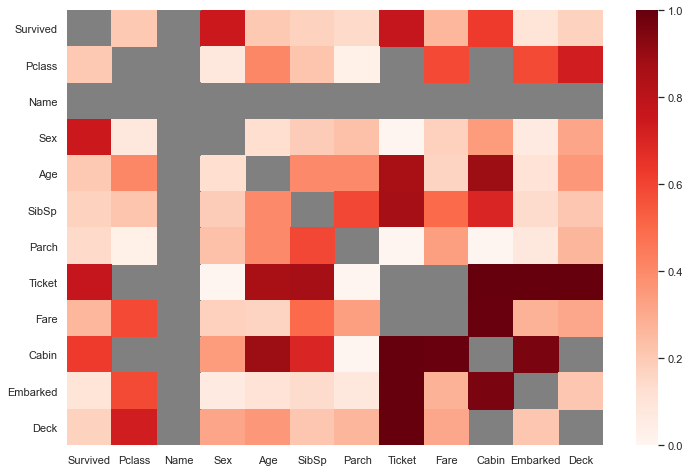

In [574]:
import phik

df = pd.read_csv(train, index_col=index, dtype=dtypes)
df['Deck'] = df['Cabin'].apply(lambda x: x[0])
df.head()

fig, ax = plt.subplots()
phik = df.phik_matrix()
g = sns.heatmap(phik, cmap='Reds', vmin=0, vmax=1, mask=(phik==1), ax=ax)
g.set_facecolor('grey')

In [577]:
allCorrelations = computeCorrelation(data)

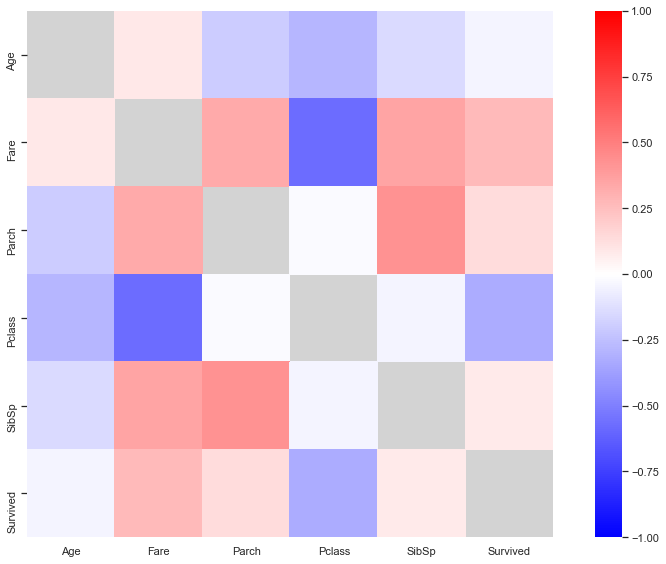

In [578]:
fig, ax = plotPairwiseCorrelation(allCorrelations)

In [579]:
missingVals = showMissing(data)
print(missingVals)

          TotalNA    PropNA
Cabin         687  0.771044
Age           177  0.198653
Embarked        2  0.002245


(<Figure size 864x576 with 4 Axes>, (<AxesSubplot:>, <AxesSubplot:>))

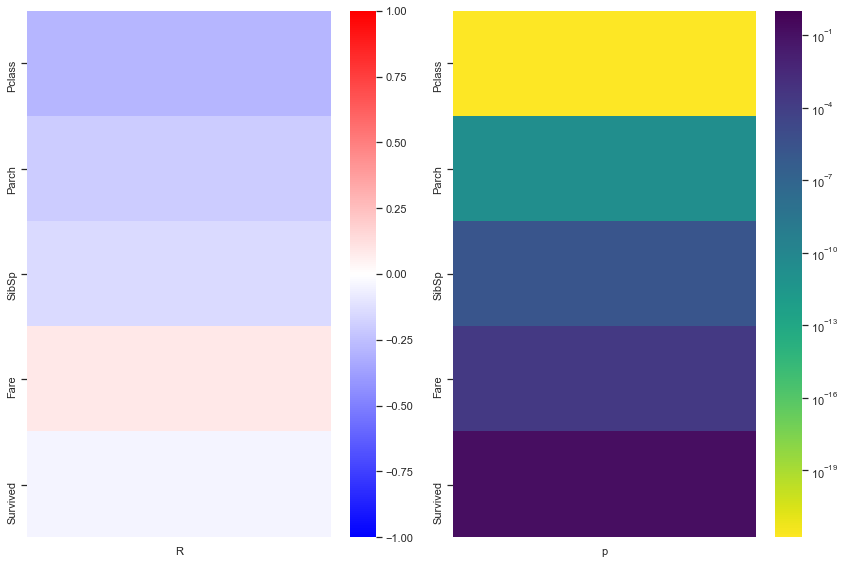

In [580]:
plotTargetCorrelation(allCorrelations, 'Age')

In [581]:
reference = 'Survived'
validFeatures = data.select_dtypes(exclude=['float', 'int']).columns
for feature in validFeatures:
    if feature == reference:
        continue
    grouping = [group[reference].dropna().values for _, group in data.groupby(feature)]
    H, p = stats.kruskal(*grouping)
    if not np.isnan(H):
        print(feature, H, p)

Name 889.9999999999997 0.4936960290919908
Sex 262.75534334779314 4.304562532204558e-59
Ticket 765.7093553556022 0.012193535356246999
Cabin 160.45955882352945 0.19531597539823756
Embarked 26.459353270240026 1.796488493944477e-06


In [582]:
data['FamSize'] = data['Parch'] + data['SibSp']
data['Alone'] = data['FamSize'] == 1
data.groupby(['Sex', 'Pclass'])[['Survived']].agg(['count', 'mean'])

Survived          
                 count      mean
Sex    Pclass                   
female 1            94  0.968085
       2            76  0.921053
       3           144  0.500000
male   1           122  0.368852
       2           108  0.157407
       3           347  0.135447

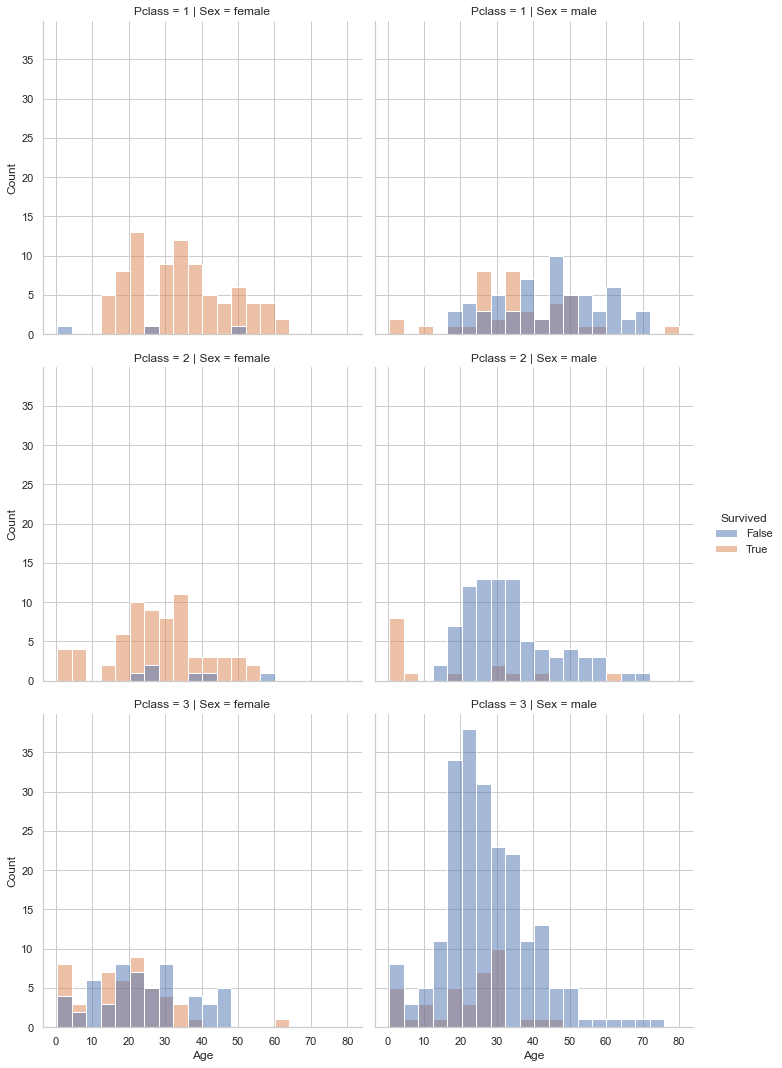

In [583]:
sns.displot(x='Age', hue='Survived', col='Sex', row='Pclass', kind='hist', data=data)

### Exploring Parch vs Survived
  - Parch feature indicates number of parents/children.

<AxesSubplot:xlabel='Parch', ylabel='Density'>

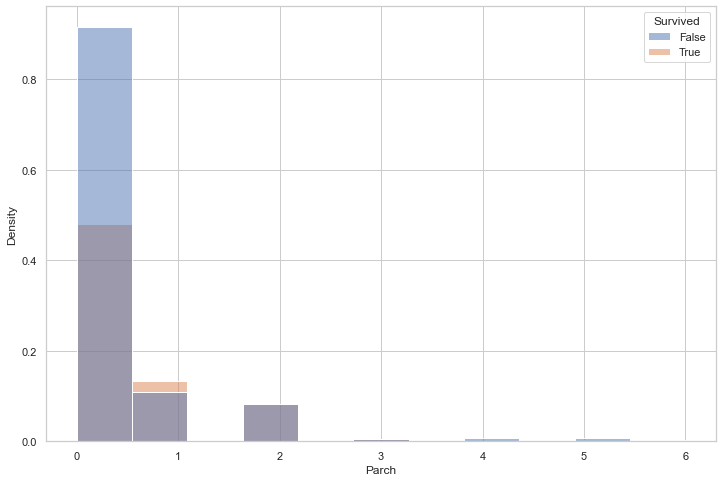

In [584]:
sns.histplot(x='Parch', hue='Survived', stat='density', data=data)

<AxesSubplot:xlabel='FamSize', ylabel='AgeGroup'>

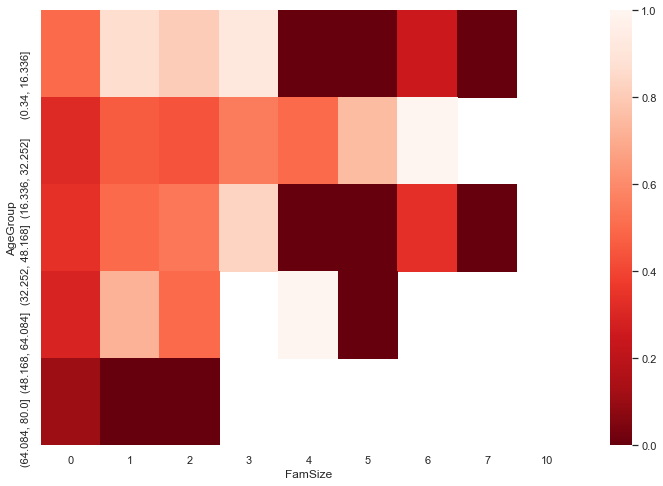

In [585]:
temp = data.copy()
temp['AgeGroup'] = pd.cut(data['Age'], 5)
temp['FamSize'] = temp['Parch'] + temp['SibSp']
temp = temp.groupby(['AgeGroup', 'FamSize'])['Survived'].mean().reset_index()
temp = temp.pivot(index='AgeGroup', columns='FamSize', values='Survived')
sns.heatmap(temp, cmap='Reds_r')

In [586]:
data['Title'] = data['Name'].apply(lambda x: re.split(',|\.', x)[1].strip())
data['Girl'] = (data['Title'] == 'Miss') & (data['Parch'] > 0)
def estimateAgeGroup(X):
    if (X['Title'] == 'Miss') & (X['Parch'] > 0):
        return 'girl'
    elif (X['Title'] == 'Master'):
        return 'boy'
    elif (X['Sex'] == 'male'):
        return 'man'
    else:
        return 'woman'
data['estAgeGroup'] = data.apply(estimateAgeGroup, axis=1)
data.groupby(['estAgeGroup', 'Pclass'])['Age'].mean()

estAgeGroup  Pclass
boy          1          5.306667
             2          2.258889
             3          5.350833
girl         1         21.000000
             2         10.538462
             3          6.903846
man          1         42.382653
             2         33.588889
             3         28.724891
woman        1         37.768116
             2         32.598361
             3         26.828947
Name: Age, dtype: float64

<AxesSubplot:xlabel='FamSize', ylabel='Survived'>

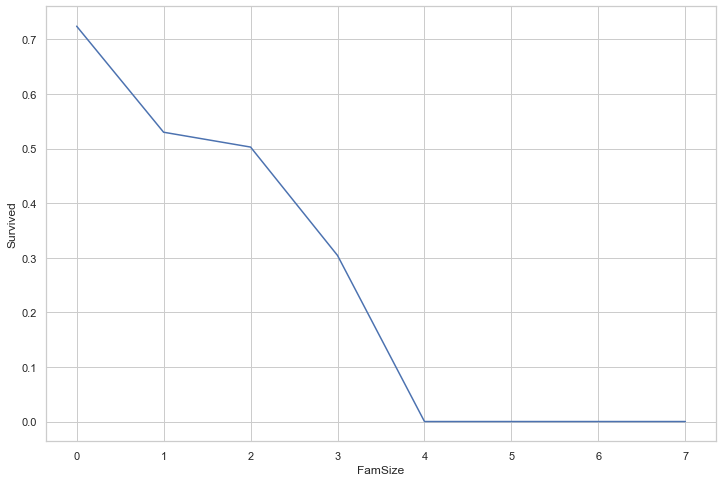

In [587]:
#data['FamSize'] = data['SibSp'].apply(lambda x: x if x > 0 else 2)
data['FamSize'] = abs(4 - (data['SibSp'] + data['Parch'] + 1))
feature = 'FamSize'
temp = data.groupby([feature])['Survived'].mean().reset_index()
sns.lineplot(x=feature, y='Survived', data=temp)

<AxesSubplot:xlabel='Parch', ylabel='SibSp'>

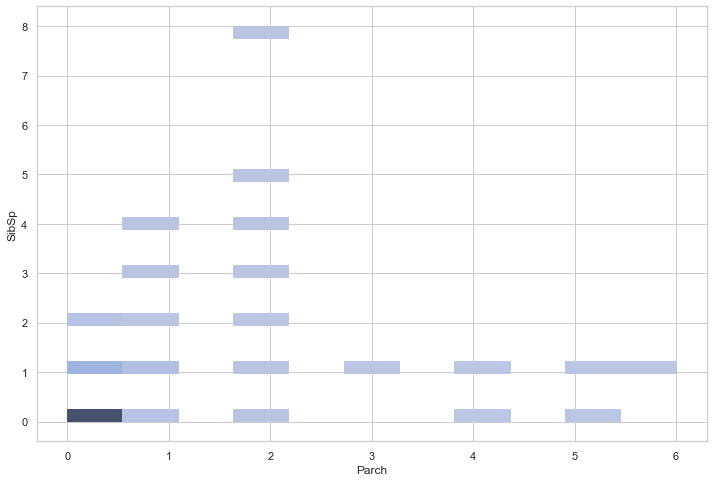

In [588]:
sns.histplot(x='Parch', y='SibSp', data=data[data['Survived']==False])

<AxesSubplot:xlabel='FareAdj', ylabel='Density'>

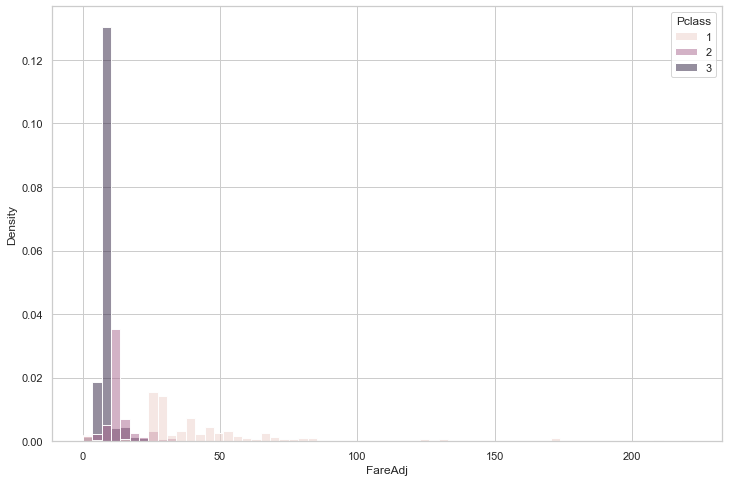

In [589]:
data['x2'] = data['Parch'] + data['SibSp'] + 1 + (data['Age'] / data['Age'].max())
data['TicketFrequency'] = data.groupby('Ticket')['Ticket'].transform('count')
data['FareAdj'] = data['Fare'] / data['TicketFrequency']
sns.histplot(x='FareAdj', hue='Pclass', stat='density', data=data)

In [590]:
maleSurviveWithFam = (data['Sex'] == 'male') & (data['Title'] != 'Master') & (data['Survived'] == 1) & (data['FamSize'] > 1)
data['Surname'] = data['Name'].apply(lambda x: re.split(',', x)[0])
names = data.loc[maleSurviveWithFam, 'Surname']
data['famSurvive'] = data['Surname'].isin(names)
data[(data['famSurvive'] == True) & (data['Sex'] != 'male') ]

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,...,FamSize,Alone,Title,Girl,estAgeGroup,x2,TicketFrequency,FareAdj,Surname,famSurvive
PassengerId,,,,,,,,,,,,,,,,,,,,,
53,True,1,"Harper, Mrs. Henry Sleeper (Myna Haxtun)",female,49.0,1,0,PC 17572,76.7292,D33,...,2,True,Mrs,False,woman,2.6125,3,25.576400,Harper,True
69,True,3,"Andersson, Miss. Erna Alexandra",female,17.0,4,2,3101281,7.9250,NaN,...,3,False,Miss,True,girl,7.2125,1,7.925000,Andersson,True
114,False,3,"Jussila, Miss. Katriina",female,20.0,1,0,4136,9.8250,NaN,...,2,True,Miss,False,woman,2.2500,1,9.825000,Jussila,True
120,False,3,"Andersson, Miss. Ellis Anna Maria",female,2.0,4,2,347082,31.2750,NaN,...,3,False,Miss,True,girl,7.0250,7,4.467857,Andersson,True
231,True,1,"Harris, Mrs. Henry Birkhardt (Irene Wallach)",female,35.0,1,0,36973,83.4750,C83,...,2,True,Mrs,False,woman,2.4375,2,41.737500,Harris,True
292,True,1,"Bishop, Mrs. Dickinson H (Helen Walton)",female,19.0,1,0,11967,91.0792,B49,...,2,True,Mrs,False,woman,2.2375,2,45.539600,Bishop,True
403,False,3,"Jussila, Miss. Mari Aina",female,21.0,1,0,4137,9.8250,NaN,...,2,True,Miss,False,woman,2.2625,1,9.825000,Jussila,True
487,True,1,"Hoyt, Mrs. Frederick Maxfield (Jane Anne Forby)",female,35.0,1,0,19943,90.0000,C93,...,2,True,Mrs,False,woman,2.4375,2,45.000000,Hoyt,True
542,False,3,"Andersson, Miss. Ingeborg Constanzia",female,9.0,4,2,347082,31.2750,NaN,...,3,False,Miss,True,girl,7.1125,7,4.467857,Andersson,True


### Surviving males

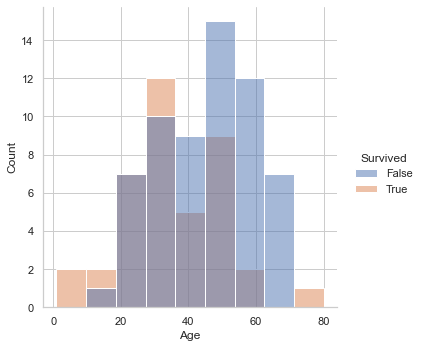

In [591]:
p1Males = data.loc[(data['Sex'] == 'male') & (data['Pclass'] == 1)]
sns.displot(x='Age', hue='Survived', kind='hist', data=p1Males)

 https://medium.com/analytics-vidhya/scikit-learn-pipelines-with-custom-transformer-a-step-by-step-guide-9b9b886fd2cc
        https://stackoverflow.com/questions/48320396/create-a-custom-sklearn-transformermixin-that-transforms-categorical-variables-c

In [592]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.datasets import fetch_openml
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, RobustScaler, PowerTransformer, KBinsDiscretizer, MinMaxScaler
from sklearn.linear_model import LogisticRegression, Lasso, RidgeCV, ElasticNet
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import make_column_selector as selector
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingClassifier
from sklearn import set_config
from xgboost import XGBClassifier
from sklearn.compose import TransformedTargetRegressor
from sklearn.model_selection import KFold
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import ParameterGrid
from sklearn.feature_selection import SelectKBest, chi2, SelectFromModel, RFECV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import StackingRegressor, RandomForestClassifier
from sklearn.svm import SVR
from sklearn.metrics import make_scorer
from sklearn.kernel_ridge import KernelRidge
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.linear_model import LinearRegression

In [593]:
set_config(display='diagram')
sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (12,8)

In [594]:
class GroupImputer(BaseEstimator, TransformerMixin):
    """ Extension of SimpleImputer to optionally impute 
        values by group and return a pandas Series. """
    
    def __init__(self, variable, by=[], strategy='median'): 
        self.variable = variable
        self.by = by
        if strategy == 'most_frequent':
            self.strategy = lambda x: x.mode().sample(1).values[0]
        else:
            self.strategy = strategy
        self.maps = []

    def fit(self, X, y=None):
        # Store impute for ungrouped data
        self.simpleImpute = X[self.variable].agg(self.strategy)
        # Store maps for all grouping levels
        for i in range(len(self.by), 0, -1):
            subBy = self.by[:i]
            mapper = X.groupby(subBy)[self.variable].agg(self.strategy)
            if i == 1:
                mapper = {(k,): v for k, v in mapper.to_dict().items()}
            self.maps.append((subBy , mapper))
        return self

    def transform(self, X, y=None):
        imputed = X[self.variable]
        for (by, mapper) in self.maps:
            fillVals = X[by].apply(tuple, axis=1).map(mapper)
            imputed = imputed.fillna(fillVals)
            if not imputed.isnull().values.any():
                break
        else:
            # Replace remaining NaN (with ungrouped)
            imputed = imputed.fillna(self.simpleImpute)
        return imputed

In [595]:
class FeatureFilter(BaseEstimator, TransformerMixin):
    """ Use for filtering columns by boolean mask """
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[:, self.columns]

In [596]:
class NoTransformer(BaseEstimator, TransformerMixin):
    """ Dummy transformer """
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return X

In [597]:
def plotFeatureImportance(X, y, prePreprocessor, estimator, vline=None):
    """ Run decision tree ensemble method on a preModel 
        pipline and plot feature importance """
    pipeline = Pipeline(steps=[
        ('prePreprocessor', prePreprocessor),
        ('selector',        estimator)])
    clf = pipeline.fit(X, y)
    columnTransformer = (
        clf.named_steps['prePreprocessor'].named_steps['columnTransform'])
    try:
        selector = clf.named_steps['prePreprocessor'].named_steps['selector']
    except KeyError:
        selector = None
    featureNames = getFeatureNames(columnTransformer, selector)
    features = (pd.DataFrame(
        {'feature': featureNames,
         'importance': clf.named_steps['selector'].feature_importances_})
        .sort_values(by=['importance'], ascending=False))
    
    print(f'Total unfiltered features: {len(featureNames)}')
    fig, ax = plt.subplots()
    sns.barplot(y='feature', x='importance', data=features, ax=ax)
    if vline is not None:
        ax.axvline(vline)
    ax.set_ylabel('')
    ax.set_xlabel('Feature importance')
    fig.tight_layout()

In [598]:
class FeatureEngineer(BaseEstimator, TransformerMixin):
    """ Custom imputation and feature engineering 
        of Titanic dataset """
    
    def __init__(self):
        self._imputes = {}
        

    def initData(self, X):
        """ Initial feature engineering for fit & transform """
        
        X['Title'] = X['Name'].apply(self.getTitle)
        X['Surname'] = X['Name'].apply(self.getSurname)
        X['FamSize'] = X['Parch'] + X['SibSp'] + 1
        X['ageGroup'] = X.apply(self.estimateAgeGroup, axis=1)
        #self.addAges(X)
        
        
    def fit(self, X, y=None):
        X = X.copy()
        self.initData(X)
        # Store surnames of all adult males (with families) that survived
        maleSurviveWithFam = (
            (X['Sex'] == 'male') & (X['Title'] != 'Master') & 
            (y == 1) & (X['FamSize'] > 1))
        self.maleNames = X.loc[maleSurviveWithFam, 'Surname']
        # Store surnames of all females (with families) that died
        femaleDieWithFam = (
            ((X['Sex'] == 'female') | (X['Title'] == 'Master')) &
            (y == 0) & (X['FamSize'] > 1))
        # Store surnames of all females (with families) that died
        self.femaleNames = X.loc[femaleDieWithFam, 'Surname']
        self._imputes['Age'] = GroupImputer(
            'Age', by=['ageGroup', 'Pclass'], strategy='median').fit(X)
        return self

    
    def transform(self, X, y=None):
        X = X.copy()
        self.initData(X)
        X['WomenOrChild'] = (X['Sex'] == 'female') | (X['Title'] == 'Master')
        X['Age'] = self._imputes['Age'].transform(X)
        X['Alone'] = X['FamSize'] == 1
        X['famSurvive'] = X['Surname'].isin(self.maleNames)
        X['famDie'] = X['Surname'].isin(self.femaleNames)
        X['Deck'] = X['Cabin'].apply(lambda x: x[0])
        return X

    
    def estimateAgeGroup(self, X):
        """ Estimate age/sex group by title for age imputation """
        # Assume unmarried with parents is a girl
        if (X['Title'] == 'Miss') & (X['Parch'] > 0):
            return 'girl'
        elif (X['Title'] == 'Master'):
            return 'boy'
        elif (X['Sex'] == 'male'):
            return 'man'
        else:
            return 'woman'    
        
        
    def getTitle(self, x):
        """ Extract title from name """
        return re.split(',|\.', x)[1].strip()
    
    
    def getSurname(self, x):
        """ Extract surname from name """
        return re.split(',', x)[0].strip()
    
    
    def addAges(self, X):
        X.loc[X['Name'] == 'Baumann, Mr. John D', 'Age'] = 48
        X.loc[X['Name'] == 'Boulos, Mr. Hanna', 'Age'] = 18
        X.loc[X['Name'] == 'Boulos, Mrs. Joseph (Sultana)', 'Age'] = 40
        X.loc[X['Name'] == 'Bourke, Miss. Mary', 'Age'] = 40
        X.loc[X['Name'] == 'Bradley, Mr. George ("George Arthur Brayton")', 'Age'] = 37
        X.loc[X['Name'] == 'Brewe, Dr. Arthur Jackson', 'Age'] = 45
        X.loc[X['Name'] == 'Cairns, Mr. Alexander', 'Age'] = 28
        X.loc[X['Name'] == 'Campbell, Mr. William', 'Age'] = 20
        X.loc[X['Name'] == 'Caram, Mrs. Joseph (Maria Elias)', 'Age'] = 18
        X.loc[X['Name'] == 'Chibnall, Mrs. (Edith Martha Bowerman)', 'Age'] = 48
        X.loc[X['Name'] == 'Clifford, Mr. George Quincy', 'Age'] = 40
        X.loc[X['Name'] == 'Cunningham, Mr. Alfred Fleming', 'Age'] = 21
        X.loc[X['Name'] == 'Davison, Mrs. Thomas Henry (Mary E Finck)', 'Age'] = 61
        X.loc[X['Name'] == 'Denkoff, Mr. Mitto', 'Age'] = 30
        X.loc[X['Name'] == 'Doharr, Mr. Tannous', 'Age'] = 28
        X.loc[X['Name'] == 'Elias, Mr. Dibo', 'Age'] = 29
        X.loc[X['Name'] == 'Emir, Mr. Farred Chehab', 'Age'] = 26
        X.loc[X['Name'] == 'Farthing, Mr. John', 'Age'] = 48
        X.loc[X['Name'] == 'Fleming, Miss. Margaret', 'Age'] = 42
        X.loc[X['Name'] == 'Flynn, Mr. James', 'Age'] = 28
        X.loc[X['Name'] == 'Flynn, Mr. John', 'Age'] = 48
        X.loc[X['Name'] == 'Foo, Mr. Choong', 'Age'] = 32
        X.loc[X['Name'] == 'Frauenthal, Mrs. Henry William (Clara Heinsheimer)', 'Age'] = 42
        X.loc[X['Name'] == 'Frost, Mr. Anthony Wood "Archie"', 'Age'] = 38
        X.loc[X['Name'] == 'Fry, Mr. Richard', 'Age'] = 39
        X.loc[X['Name'] == 'Garfirth, Mr. John', 'Age'] = 21
        X.loc[X['Name'] == 'Glynn, Miss. Mary Agatha', 'Age'] = 18
        X.loc[X['Name'] == 'Goldenberg, Mrs. Samuel L (Edwiga Grabowska)', 'Age'] = 46
        X.loc[X['Name'] == 'Hagland, Mr. Ingvald Olai Olsen', 'Age'] = 28
        X.loc[X['Name'] == 'Hagland, Mr. Konrad Mathias Reiersen', 'Age'] = 19
        X.loc[X['Name'] == 'Harknett, Miss. Alice Phoebe', 'Age'] = 21
        X.loc[X['Name'] == 'Harrington, Mr. Charles H', 'Age'] = 37
        X.loc[X['Name'] == 'Hart, Mr. Henry', 'Age'] = 30
        X.loc[X['Name'] == 'Hawksford, Mr. Walter James', 'Age'] = 45
        X.loc[X['Name'] == 'Healy, Miss. Hanora "Nora"', 'Age'] = 33
        X.loc[X['Name'] == 'Henry, Miss. Delia', 'Age'] = 22
        X.loc[X['Name'] == 'Hoyt, Mr. William Fisher', 'Age'] = 43
        X.loc[X['Name'] == 'Ivanoff, Mr. Kanio', 'Age'] = 20
        X.loc[X['Name'] == 'Jardin, Mr. Jose Neto', 'Age'] = 21
        X.loc[X['Name'] == 'Jermyn, Miss. Annie', 'Age'] = 26
        X.loc[X['Name'] == 'Johannesen-Bratthammer, Mr. Bernt', 'Age'] = 29
        X.loc[X['Name'] == 'Johnston, Miss. Catherine Helen "Carrie"', 'Age'] = 7
        X.loc[X['Name'] == 'Johnston, Mr. Andrew G', 'Age'] = 35
        X.loc[X['Name'] == 'Kassem, Mr. Fared', 'Age'] = 19
        X.loc[X['Name'] == 'Keane, Miss. Nora A', 'Age'] = 46
        X.loc[X['Name'] == 'Keane, Mr. Andrew "Andy"', 'Age'] = 23
        X.loc[X['Name'] == 'Keefe, Mr. Arthur', 'Age'] = 44
        X.loc[X['Name'] == 'Kelly, Miss. Anna Katherine "Annie Kate"', 'Age'] = 20
        X.loc[X['Name'] == 'Kelly, Miss. Mary', 'Age'] = 22
        X.loc[X['Name'] == 'Kenyon, Mrs. Frederick R (Marion)', 'Age'] = 41
        X.loc[X['Name'] == 'Kiernan, Mr. Philip', 'Age'] = 22
        X.loc[X['Name'] == 'Kilgannon, Mr. Thomas J', 'Age'] = 21
        X.loc[X['Name'] == 'Klaber, Mr. Herman', 'Age'] = 41
        X.loc[X['Name'] == 'Knight, Mr. Robert J', 'Age'] = 42
        X.loc[X['Name'] == 'Lahoud, Mr. Sarkis', 'Age'] = 35
        X.loc[X['Name'] == 'Laleff, Mr. Kristo', 'Age'] = 23
        X.loc[X['Name'] == 'Lam, Mr. Ali', 'Age'] = 38
        X.loc[X['Name'] == 'Lam, Mr. Len', 'Age'] = 23
        X.loc[X['Name'] == 'Lefebre, Master. Henry Forbes', 'Age'] = 50
        X.loc[X['Name'] == 'Lefebre, Miss. Ida', 'Age'] = 3
        X.loc[X['Name'] == 'Lefebre, Miss. Jeannie', 'Age'] = 8
        X.loc[X['Name'] == 'Lefebre, Miss. Mathilde', 'Age'] = 12
        X.loc[X['Name'] == 'Leitch, Miss. Jessie Wills', 'Age'] = 31
        X.loc[X['Name'] == 'Lennon, Mr. Denis', 'Age'] = 20
        X.loc[X['Name'] == 'Lewy, Mr. Ervin G', 'Age'] = 30
        X.loc[X['Name'] == 'Madigan, Miss. Margaret "Maggie"', 'Age'] = 21
        X.loc[X['Name'] == 'Maisner, Mr. Simon', 'Age'] = 34
        X.loc[X['Name'] == 'Mamee, Mr. Hanna', 'Age'] = 20
        X.loc[X['Name'] == 'Mannion, Miss. Margareth', 'Age'] = 28
        X.loc[X['Name'] == 'Marechal, Mr. Pierre', 'Age'] = 29
        X.loc[X['Name'] == 'Masselmani, Mrs. Fatima', 'Age'] = 22
        X.loc[X['Name'] == 'McCormack, Mr. Thomas Joseph', 'Age'] = 19
        X.loc[X['Name'] == 'McCoy, Miss. Agnes', 'Age'] = 29
        X.loc[X['Name'] == 'McCoy, Mr. Bernard', 'Age'] = 24
        X.loc[X['Name'] == 'McDermott, Miss. Brigdet Delia', 'Age'] = 31
        X.loc[X['Name'] == 'McEvoy, Mr. Michael', 'Age'] = 20
        X.loc[X['Name'] == 'McGovern, Miss. Mary', 'Age'] = 20
        X.loc[X['Name'] == 'McMahon, Mr. Martin', 'Age'] = 19
        X.loc[X['Name'] == 'Meanwell, Miss. (Marion Ogden)', 'Age'] = 62
        X.loc[X['Name'] == 'Meek, Mrs. Thomas (Annie Louise Rowley)', 'Age'] = 32
        X.loc[X['Name'] == 'Mernagh, Mr. Robert', 'Age'] = 28
        X.loc[X['Name'] == 'Meyer, Mrs. Edgar Joseph (Leila Saks)', 'Age'] = 25
        X.loc[X['Name'] == 'Mitkoff, Mr. Mito', 'Age'] = 23
        X.loc[X['Name'] == 'Mockler, Miss. Helen Mary "Ellie"', 'Age'] = 23
        X.loc[X['Name'] == 'Moore, Mr. Leonard Charles', 'Age'] = 19
        X.loc[X['Name'] == 'Moran, Miss. Bertha', 'Age'] = 28
        X.loc[X['Name'] == 'Moran, Mr. Daniel J', 'Age'] = 28
        X.loc[X['Name'] == 'Moran, Mr. James', 'Age'] = 28
        X.loc[X['Name'] == 'Morrow, Mr. Thomas Rowan', 'Age'] = 31
        X.loc[X['Name'] == 'Moss, Mr. Albert Johan', 'Age'] = 29
        X.loc[X['Name'] == 'Moubarek, Master. Gerios', 'Age'] = 7
        X.loc[X['Name'] == 'Moubarek, Master. Halim Gonios ("William George")', 'Age'] = 4
        X.loc[X['Name'] == 'Moussa, Mrs. (Mantoura Boulos)', 'Age'] = 35
        X.loc[X['Name'] == 'Moutal, Mr. Rahamin Haim', 'Age'] = 28
        X.loc[X['Name'] == 'Mullens, Miss. Katherine "Katie"', 'Age'] = 21
        X.loc[X['Name'] == 'Murdlin, Mr. Joseph', 'Age'] = 22
        X.loc[X['Name'] == 'Murphy, Miss. Katherine "Kate"', 'Age'] = 18
        X.loc[X['Name'] == 'Murphy, Miss. Margaret Jane', 'Age'] = 25
        X.loc[X['Name'] == 'Nankoff, Mr. Minko', 'Age'] = 32
        X.loc[X['Name'] == 'Nenkoff, Mr. Christo', 'Age'] = 22
        X.loc[X['Name'] == 'O\'Brien, Mr. Thomas', 'Age'] = 26
        X.loc[X['Name'] == 'O\'Brien, Mr. Timothy', 'Age'] = 22
        X.loc[X['Name'] == 'O\'Brien, Mrs. Thomas (Johanna "Hannah" Godfrey)', 'Age'] = 27
        X.loc[X['Name'] == 'O\'Connell, Mr. Patrick D', 'Age'] = 18
        X.loc[X['Name'] == 'O\'Connor, Mr. Maurice', 'Age'] = 15
        X.loc[X['Name'] == 'O\'Driscoll, Miss. Bridget', 'Age'] = 27
        X.loc[X['Name'] == 'O\'Dwyer, Miss. Ellen "Nellie"', 'Age'] = 22
        X.loc[X['Name'] == 'O\'Leary, Miss. Hanora "Norah"', 'Age'] = 16
        X.loc[X['Name'] == 'O\'Sullivan, Miss. Bridget Mary', 'Age'] = 21
        X.loc[X['Name'] == 'Olsen, Mr. Ole Martin', 'Age'] = 27
        X.loc[X['Name'] == 'Padro y Manent, Mr. Julian', 'Age'] = 26
        X.loc[X['Name'] == 'Parkes, Mr. Francis "Frank"', 'Age'] = 21
        X.loc[X['Name'] == 'Parr, Mr. William Henry Marsh', 'Age'] = 29
        X.loc[X['Name'] == 'Paulner, Mr. Uscher', 'Age'] = 16
        X.loc[X['Name'] == 'Peduzzi, Mr. Joseph', 'Age'] = 24
        X.loc[X['Name'] == 'Pernot, Mr. Rene', 'Age'] = 39
        X.loc[X['Name'] == 'Peter, Miss. Anna', 'Age'] = 2
        X.loc[X['Name'] == 'Peter, Mrs. Catherine (Catherine Rizk)', 'Age'] = 23
        X.loc[X['Name'] == 'Peters, Miss. Katie', 'Age'] = 27
        X.loc[X['Name'] == 'Petroff, Mr. Pastcho ("Pentcho")', 'Age'] = 29
        X.loc[X['Name'] == 'Plotcharsky, Mr. Vasil', 'Age'] = 27
        X.loc[X['Name'] == 'Radeff, Mr. Alexander', 'Age'] = 27
        X.loc[X['Name'] == 'Razi, Mr. Raihed', 'Age'] = 30
        X.loc[X['Name'] == 'Reed, Mr. James George', 'Age'] = 18
        X.loc[X['Name'] == 'Risien, Mr. Samuel Beard', 'Age'] = 69
        X.loc[X['Name'] == 'Robbins, Mr. Victor', 'Age'] = 45
        X.loc[X['Name'] == 'Rogers, Mr. William John', 'Age'] = 29
        X.loc[X['Name'] == 'Rommetvedt, Mr. Knud Paust', 'Age'] = 49
        X.loc[X['Name'] == 'Rood, Mr. Hugh Roscoe', 'Age'] = 39
        X.loc[X['Name'] == 'Ryan, Mr. Patrick', 'Age'] = 32
        X.loc[X['Name'] == 'Saad, Mr. Amin', 'Age'] = 30
        X.loc[X['Name'] == 'Saalfeld, Mr. Adolphe', 'Age'] = 47
        X.loc[X['Name'] == 'Sadlier, Mr. Matthew', 'Age'] = 19
        X.loc[X['Name'] == 'Sage, Master. Thomas Henry', 'Age'] = 5
        X.loc[X['Name'] == 'Sage, Miss. Constance Gladys', 'Age'] = 7
        X.loc[X['Name'] == 'Sage, Miss. Dorothy Edith "Dolly"', 'Age'] = 14
        X.loc[X['Name'] == 'Sage, Miss. Stella Anna', 'Age'] = 20
        X.loc[X['Name'] == 'Sage, Mr. Douglas Bullen', 'Age'] = 18
        X.loc[X['Name'] == 'Sage, Mr. Frederick', 'Age'] = 16
        X.loc[X['Name'] == 'Sage, Mr. George John Jr', 'Age'] = 19
        X.loc[X['Name'] == 'Samaan, Mr. Youssef', 'Age'] = 16
        X.loc[X['Name'] == 'Scanlan, Mr. James', 'Age'] = 20
        X.loc[X['Name'] == 'Sdycoff, Mr. Todor', 'Age'] = 42
        X.loc[X['Name'] == 'Shellard, Mr. Frederick William', 'Age'] = 55
        X.loc[X['Name'] == 'Shorney, Mr. Charles Joseph', 'Age'] = 22
        X.loc[X['Name'] == 'Simmons, Mr. John', 'Age'] = 40
        X.loc[X['Name'] == 'Sirota, Mr. Maurice', 'Age'] = 19
        X.loc[X['Name'] == 'Slabenoff, Mr. Petco', 'Age'] = 42
        X.loc[X['Name'] == 'Slocovski, Mr. Selman Francis', 'Age'] = 20
        X.loc[X['Name'] == 'Smiljanic, Mr. Mile', 'Age'] = 37
        X.loc[X['Name'] == 'Smith, Mr. Richard William', 'Age'] = 57
        X.loc[X['Name'] == 'Smith, Mr. Thomas', 'Age'] = 26
        X.loc[X['Name'] == 'Spencer, Mrs. William Augustus (Marie Eugenie)', 'Age'] = 48
        X.loc[X['Name'] == 'Staneff, Mr. Ivan', 'Age'] = 23
        X.loc[X['Name'] == 'Stewart, Mr. Albert A', 'Age'] = 64
        X.loc[X['Name'] == 'Taylor, Mrs. Elmer Zebley (Juliet Cummins Wright)', 'Age'] = 49
        X.loc[X['Name'] == 'Thorne, Mrs. Gertrude Maybelle', 'Age'] = 37
        X.loc[X['Name'] == 'Thorneycroft, Mr. Percival', 'Age'] = 36
        X.loc[X['Name'] == 'Thorneycroft, Mrs. Percival (Florence Kate White)', 'Age'] = 32
        X.loc[X['Name'] == 'Tobin, Mr. Roger', 'Age'] = 20
        X.loc[X['Name'] == 'Todoroff, Mr. Lalio', 'Age'] = 23
        X.loc[X['Name'] == 'Toufik, Mr. Nakli', 'Age'] = 17
        X.loc[X['Name'] == 'Watson, Mr. Ennis Hastings', 'Age'] = 18
        X.loc[X['Name'] == 'Webber, Mr. James', 'Age'] = 66
        X.loc[X['Name'] == 'Willey, Mr. Edward', 'Age'] = 20
        X.loc[X['Name'] == 'Williams, Mr. Charles Eugene', 'Age'] = 23
        X.loc[X['Name'] == 'Williams, Mr. Howard Hugh "Harry"', 'Age'] = 28
        X.loc[X['Name'] == 'Williams-Lambert, Mr. Fletcher Fellows', 'Age'] = 43
        X.loc[X['Name'] == 'Wiseman, Mr. Phillippe', 'Age'] = 53
        X.loc[X['Name'] == 'Woolner, Mr. Hugh', 'Age'] = 45
        X.loc[X['Name'] == 'Yousif, Mr. Wazli', 'Age'] = 23
        X.loc[X['Name'] == 'Yousseff, Mr. Gerious', 'Age'] = 33
        X.loc[X['Name'] == 'Zabour, Miss. Thamine', 'Age'] = 19
        X.loc[X['Name'] == 'van Melkebeke, Mr. Philemon', 'Age'] = 23


In [599]:
def getFeatureNames(columnTransformer, selector=None):
    """ Extract feature names from column transformer. 
        If transformers are pipelines then encoding step
        should be last step of that pipeline
        Ref: https://github.com/scikit-learn/scikit-learn/issues/12525 
    """
    colNames = np.array([])
    for tupleTransformer in columnTransformer.transformers_[:-1]:
        if isinstance(tupleTransformer[1], Pipeline): 
            transformer = tupleTransformer[1].steps[-1][1]
        else:
            transformer = tupleTransformer[1]
        try:
            names = transformer.get_feature_names()
        except AttributeError:
            names = tupleTransformer[2]
        # This is for kBinDiscretizers, which have n_bins_ method
        if (isinstance(transformer, KBinsDiscretizer)
                and transformer.encode != 'ordinal'):
            if transformer.encode != 'ordinal':
                nbins = transformer.n_bins_
                newNames = []
                for col, n in zip(names, nBins):
                    newNames = [f'{col}-{i}' for i in range(n)]
                names = newNames
        colNames = np.append(colNames, names)
    if selector is not None:
        colNames = colNames[selector.get_support()]
    return colNames

In [600]:
X = pd.read_csv(train, index_col=index, dtype=dtypes)
y = X.pop(target)

split = train_test_split(X, y, random_state=0, train_size=0.8, test_size=0.2)
X_train, X_valid, y_train, y_valid = map(lambda x: x.copy(), split)

### Data pre-processing step
  - I used a ColumnTransformer to apply custom pipeline to subsets of features.
  - I use a custom NoTransformer() class to include any features that don't need processing.
  - All other features are dropped by default.

In [601]:
AgeDiscretizer = Pipeline(steps=[
    ('discrete', KBinsDiscretizer(encode='ordinal', strategy='kmeans'))
])
# Explicity defined categories to ensure these are consistent during cross validation
DeckTransformer = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='constant', fill_value='UnknownDeck')),
    ('encode', OneHotEncoder(
        handle_unknown='ignore', 
        categories=[['UnknownDeck', 'C', 'E', 'G', 'D', 'A', 'B', 'F', 'T']]))
])

In [602]:
transformers = ([
    ('Pclass',  OneHotEncoder(handle_unknown='ignore'),  ['Pclass']),
    ('Age',     AgeDiscretizer,    ['Age']),
    ('None',    NoTransformer(),   ['famDie', 'famSurvive', 'FamSize', 'WomenOrChild']),
])
preprocessor = ColumnTransformer(transformers=transformers, remainder='drop')

In [603]:
# Define a preModel pipeline distinct from modelling step
dataEngineering = Pipeline(steps=[
    ('engineer',        FeatureEngineer()),
    ('columnTransform', preprocessor),
])

## Assessing feature importance

Total unfiltered features: 8


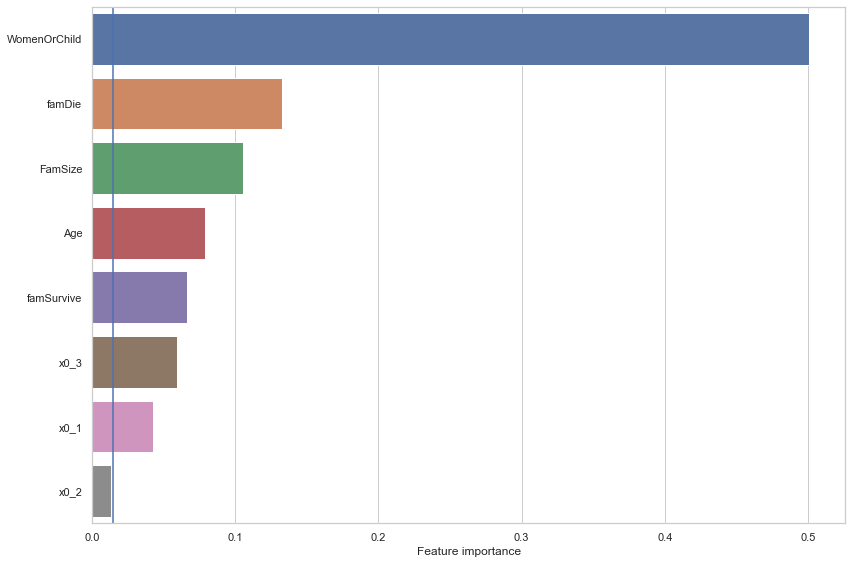

In [604]:
selectEstimator = RandomForestClassifier(random_state=1, n_estimators=500, max_features='sqrt')
plotFeatureImportance(X_train, y_train, dataEngineering, selectEstimator, 0.015)

### Perform feature selection
  - Combine the preProcess pipeline with feature selector.
  - Run feature selection and identify selected features.
  - Selected features and passed to parameter hypertuning pipeline (stage 3).

In [605]:
# Configure the cross-validation procedure
cv = KFold(n_splits=5, shuffle=True, random_state=1)
nJobs = 4

In [606]:
featureSelector = Pipeline(steps=[
    ('preProcess',    dataEngineering),
    ('selector',      RFECV(selectEstimator, cv=cv, scoring='accuracy')),
])

In [607]:
# Fit data to pipeline
featureSelector.fit(X_train, y_train)
# Extract columnTransformer and selector to extract feature names
columnTransformer = featureSelector.named_steps['preProcess'].named_steps['columnTransform']
selector = featureSelector.named_steps['selector']
selectedFeatures = selector.get_support()
featureNames = getFeatureNames(columnTransformer, selector)
# Create dataframe of transformed data
transformedDF = pd.DataFrame(
    featureSelector.transform(X_valid), 
    columns=featureNames)

transformedDF.head()

,x0_3,Age,famDie,famSurvive,FamSize,WomenOrChild
0,1,1,False,False,1,False
1,1,1,False,False,1,False
2,1,0,True,False,6,True
3,0,2,False,False,2,True
4,1,1,False,False,3,True


### Estimator hypertuning
  - Build a fresh pipeline seperator from the feature selector.
  - The custom FeatureFilter() transformer filters unselected features.
  - I do this because I don't want to perform feature selection within a grid search.

In [608]:
fullModel = Pipeline(steps=[
    ('preProcess',    dataEngineering),
    ('featureFilter', FeatureFilter(selectedFeatures)),
    ('model',         RandomForestClassifier(random_state=1)),
])

In [629]:
params =([
    {'preProcess__columnTransform__Age__discrete__n_bins':  Integer(2, 6),
     'model__n_estimators':      Integer(100, 1000),
     'model__max_depth':         Integer(3, 20),
     'model__criterion':         Categorical(['gini', 'entropy']),
     'model__max_features':      Integer(1, len(featureNames)),
},
])

In [630]:
gridSearch = BayesSearchCV(
    fullModel, params, scoring='accuracy', random_state=1,
    cv=cv, refit=True, n_jobs=nJobs, n_iter=250, verbose=1)
gridSearch.fit(X, y)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    3.6s finished


BayesSearchCV(cv=KFold(n_splits=5, random_state=1, shuffle=True),
              estimator=Pipeline(steps=[('preProcess',
                                         Pipeline(steps=[('engineer',
                                                          FeatureEngineer()),
                                                         ('columnTransform',
                                                          ColumnTransformer(transformers=[('Pclass',
                                                                                           OneHotEncoder(handle_unknown='ignore'),
                                                                                           ['Pclass']),
                                                                                          ('Age',
                                                                                           Pipeline(steps=[('discrete',
                                                                                                            KBinsDiscretizer(encode='ordinal',
                                                                                                                             strategy='kmeans'))...
                                         FeatureFilter(columns=array([False, False,  True,  True,  True,  True,  True,  True]))),
                                        ('model',
                                         RandomForestClassifier(random_state=1))]),
              n_iter=1, n_jobs=4, random_state=1, scoring='accuracy',
              search_spaces=[{'model__criterion': ['gini'],
                              'model__max_depth': [9],
                              'model__max_features': [1],
                              'model__n_estimators': [467],
                              'preProcess__columnTransform__Age__discrete__n_bins': [3]}],
              verbose=1)

In [631]:
gridSearch.best_params_

params =([
    {'preProcess__columnTransform__Age__discrete__n_bins':  [3],
     'model__n_estimators':      [467],
     'model__max_depth':         [9],
     'model__criterion':         ['gini'],
     'model__max_features':      [1],
},
])

In [632]:
X_test = pd.read_csv(test, index_col=index, dtype=dtypes)
correct = pd.read_csv('submissionTrue.csv')['Survived']
myBest = pd.read_csv('submissionBest.csv')['Survived']
currentPredict = gridSearch.predict(X_test)
actualScore = (correct == currentPredict).sum() / len(correct)
print(actualScore)

0.7990430622009569


### Generate predictions
 - Refit model with full test dataset

In [628]:
X_test = pd.read_csv(test, index_col=index, dtype=dtypes)
predictions = gridSearch.predict(X_test).astype(int)
submission = pd.DataFrame({'PassengerId':X_test.index,'Survived': predictions})
submission.to_csv('submission.csv', index=False)

## Hard encoded rules

In [433]:
class RuleAugmentedEstimator(BaseEstimator, ClassifierMixin):
    """ Augments sklearn estimators with rule-based logic.
        This class is a wrapper class for sklearn estimators with the additional
    possibility of adding rule-based logic to the underlying estimator.
    The provided rules are hard-coded and take precedence over the underlying
    estimator's predictions.
    """

    def __init__(self, baseModel: BaseEstimator):  
        self.baseModel = baseModel

        
    def _getBaseModelData(self, X, y):
        """Filters the training data for data points not affected by the rules."""
        
        train_x = X
        mask = (train_x['Sex'] == 'female') & (train_x['Pclass'].isin([1, 2]))
        mask = np.logical_not(mask)
        train_x = train_x.loc[mask]
        train_y = y.loc[mask]
        
        train_x = train_x.reset_index(drop=True)
        train_y = train_y.reset_index(drop=True)
        
        return train_x, train_y   
    
            
    def getTitle(self, x):
        """ Extract title from name """
        return re.split(',|\.', x)[1].strip()

    
    def fit(self, X, y, **kwargs):
        train_x, train_y = self._getBaseModelData(X, y)
        self.baseModel.fit(train_x, train_y, **kwargs)
    
    
    def predict(self, X: pd.DataFrame) -> np.array:
        """Gets predictions for the provided feature data.
        
        The predicitons are evaluated using the provided rules wherever possible
        otherwise the underlying estimator is used.
        
        Args:
            X: The feature data to evaluate predictions for.
        
        Returns:
            np.array: Evaluated predictions.
        """
        
        p_X = X.copy()
        p_X['prediction'] = np.nan
        p_X.loc[(p_X['Sex'] == 'female') & (p_X['Pclass'].isin([1, 2])), 'prediction'] = True
        
        if len(p_X.loc[p_X['prediction'].isna()].index != 0):
            base_X = p_X.loc[p_X['prediction'].isna()].copy()
            base_X.drop('prediction', axis=1, inplace=True)
            print(base_X)
            p_X.loc[p_X['prediction'].isna(), 'prediction'] = self.baseModel.predict(base_X)
        return list(p_X['prediction'])
    
    
    def get_params(self, deep: bool = True):
        return self.baseModel.get_params(deep=deep)
    


In [434]:
a = RuleAugmentedEstimator(gridSearch)
a.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    1.1s finished


In [435]:
currentPredict = a.predict(X_test)
actualScore = (correct == currentPredict).sum() / len(correct)

             Pclass                                          Name     Sex  \
PassengerId                                                                 
892               3                              Kelly, Mr. James    male   
893               3              Wilkes, Mrs. James (Ellen Needs)  female   
894               2                     Myles, Mr. Thomas Francis    male   
895               3                              Wirz, Mr. Albert    male   
896               3  Hirvonen, Mrs. Alexander (Helga E Lindqvist)  female   
...             ...                                           ...     ...   
1304              3                Henriksson, Miss. Jenny Lovisa  female   
1305              3                            Spector, Mr. Woolf    male   
1307              3                  Saether, Mr. Simon Sivertsen    male   
1308              3                           Ware, Mr. Frederick    male   
1309              3                      Peter, Master. Michael J    male   

## Model without Maching Learning
  - **Rules**
    - All women and children (individuals with Master title) survive.
    - All men die.
  - Public score of this model: 0.75358

In [ ]:
class WCsurvive(BaseEstimator, ClassifierMixin):
    def fit(self, X, y):
        return self
     
    def predict(self, X):
        X = X.copy()
        X['Title'] = X['Name'].apply(self.getTitle)
        return X.apply(self.rule, axis=1)
    
    def rule(self, X):
        if (X['Sex'] == 'female') | (X['Title'] == 'Master'):
            return 1
        else:
            return 0
        
    def getTitle(self, x):
        return re.split(',|\.', x)[1].strip()

In [ ]:
trainingScore = WCsurvive().score(data, data['Survived'])
print(f'Training Score: {trainingScore:3.3%}')

In [ ]:
X_test = pd.read_csv(test, index_col=index, dtype=dtypes)
predictions = WCsurvive().predict(X_test)
submission = pd.DataFrame(
    {'PassengerId':X_test.index,'Survived': predictions})
submission.to_csv('submissionWCsurvive.csv', index=False)